# XY-calibration (QSO)

In [100]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    try:
        os.chdir(basepath)
    except NameError:
        os.chdir("../..")
        basepath = os.path.abspath("")
        os.chdir(basepath)
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git

In [101]:
%pwd

'/home/dvibert/work/FireBallPipe'


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [102]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from functools import reduce
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
Elg = 1.0063 #2023 FTS #0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg =  1.0272 #2023 FTS #1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
After calibration of the encoders, El is 0.09258 ''/inc and Ce is 0.01027 ''/inc


In [103]:
os.path.abspath("")

'/home/dvibert/work/FireBallPipe'

## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [104]:
# prerequisites:
Field = "QSO"
previous_xy_mapping = "Calibration/Mappings/2023/XY/QSO_XY_gamma1.00_230821.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-0-QSO_230821_-102.5_-110degres_good.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [105]:
# # load model from previous XY calib 
# G2UV = Guider2UV(filename=previous_xy_mapping)
# #changer de centre 
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.1038940*u.deg, 1.594590*u.deg), rotation=(90-100)*u.deg, gamma=1)#QSO1
		
	
# # eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
# G2UV.mask_rotation = 0.0*u.arcmin
# G2UV.FieldP.gamma = 1. 
# G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# print(G2UV)

# # if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# # G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
# #                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
# #                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     raise ValueError("Please verify the initialization mapping")
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"

F1_stars = Table.read(star_target_path).to_pandas()

# stars =  [2, 4, 5, 6, 7] #QSOV 1
stars =  [13,14,15] #QSOV 1
selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))




## Alternative initialisation for new fields:
---------------------------------------

In [106]:

f_ra, f_dec, f_rot = 0.038940, 1.394590, 90-100
f_ra, f_dec, f_rot = 14.62883, 0.00512, 90-100
Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# get FOVcenter & guider wcs from another field
#  put pkl from a functionning mapping from another field
G2UVinit = Guider2UV(filename=previous_xy_mapping)
FOVcenter = G2UVinit.FOV_center_guider_coord.copy()
guider_wcs = G2UVinit.GuiderP.w.copy()
# target geometry
G2UVtrue = Guider2UV(Field_center=Field_center,
                     Field_rotation= f_rot * u.deg,
                     Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
                     FOVcenter_guider_coord=FOVcenter,
                     guider_wcs = guider_wcs,
                     mask_rotation = 70*u.arcmin #30*u.arcmin
                    )

# set a constant plate scale
G2UVtrue.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtrue.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)

#G2UVtrue.caroussel_rotation = 100*u.arcsec
G2UVtrue.tank_rotation = 20*u.deg

# starting geometry (perturbed from true one, goal is to update and reach the true one)                      
G2UV = G2UVtrue.copy()
# change FOV and mask rotation 
# goal : be able to reach the simu values...
deltarot = 70*u.arcmin
deltax = 100*u.arcsec
deltay = -30*u.arcsec
G2UV.mask_rotation = G2UVtrue.mask_rotation - deltarot
newFOVcenter = coordinates.SkyCoord(FOVcenter.lon - deltax, FOVcenter.lat - deltay, frame=FOVcenter.frame)
G2UV.FOV_center_guider_coord = newFOVcenter

#  observation geometry (used to compute the observations of the starting geometry, knowing the true one)
G2UVobs = G2UV.copy()
# change FOV and mask rotation 
# goal : obsbe able to reach the simu values...
G2UVobs.mask_rotation = G2UV.mask_rotation - deltarot
deltarot_rad = deltarot.to(u.radian).value
new_offset = [newFOVcenter.lon, newFOVcenter.lat]
new_offset = [  new_offset[0] + deltarot_rad*new_offset[1],
                -deltarot_rad*new_offset[0] + new_offset[1] ] 
new_offset = [new_offset[0] - deltax, new_offset[1] - deltay]

obsFOVcenter = coordinates.SkyCoord(new_offset[0], new_offset[1], frame=FOVcenter.frame)
G2UVobs.FOV_center_guider_coord = obsFOVcenter


FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.19228221, -0.02488423)>
FOV center pixel position in guider [array(1394.82302914), array(444.81696042)]


In [107]:
print(G2UVtrue, G2UVtrue.FOV_center_guider_coord.to_string('dms'))


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (14.62883, 0.00512)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 70.0 arcmin
    FOV center in guider: [1405.80024479]x[184.44357635] pix
 ['0d11m43.03989221s -0d05m31.80034734s']


In [92]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([0.6,1.4])
diffuse_offset = np.array([0,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

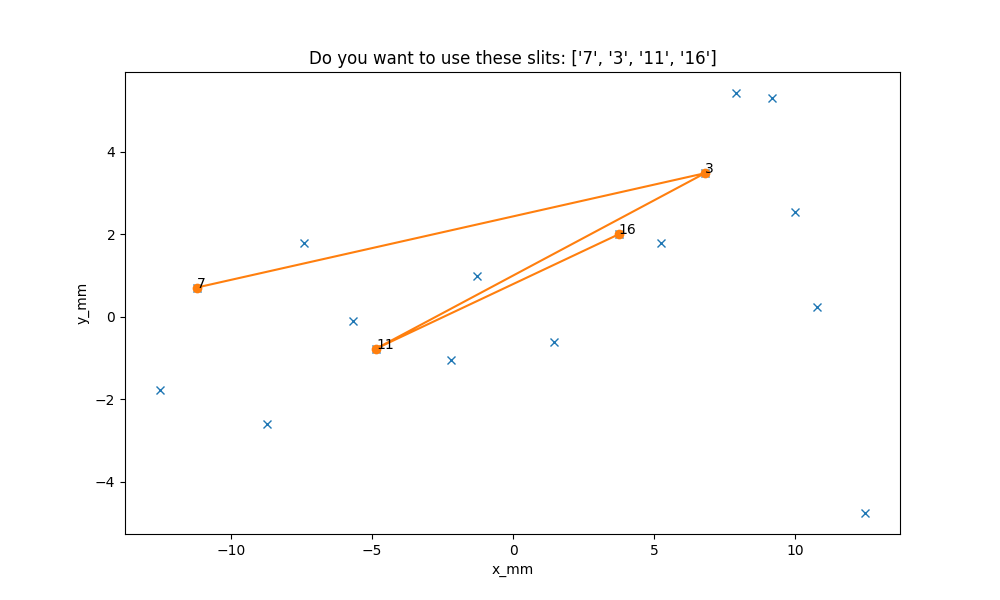

In [93]:
slits =[ '9', '16', '7',"3","10"]#pass only on QSO 3
slits =[  '7',"3","11","16"]# short pass
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.ylabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path
stars_and_slits = vstack([selected_stars["RA","DEC"],selected_slits["RA","DEC"]])

In [94]:
moves, flags, slits_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
slits_coords = slits_coords[:len(slits)]

slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 160.5 arcsec ; CE: -417.3 arcsec
EL: 531.2 arcsec ; CE: 244.3 arcsec
EL: 193.2 arcsec ; CE: -149.2 arcsec
EL: 427.9 arcsec ; CE: 146.1 arcsec

siderostat moves sequence: 


In [95]:
## simulate obs (using G2UVobs)

moves, flags, slits_coords_obs = G2UVobs.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
slits_coords_obs = slits_coords_obs[:len(slits)]

slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 119.4 arcsec ; CE: -428.7 arcsec
EL: 476.5 arcsec ; CE: 240.3 arcsec
EL: 146.6 arcsec ; CE: -159.9 arcsec
EL: 375.2 arcsec ; CE: 140.1 arcsec

siderostat moves sequence: 


In [96]:
stars_and_slits

RA,DEC
float64,float64
14.779574,-0.145077
14.642088,-0.25461
14.578173,-0.349763
14.364510000000001,-0.02437
14.772960000000001,0.11435
14.51883,-0.03288
14.70766,0.06711


Fitting rotation and translation
theta: 70.0 arcmin
dx: 100.0 arcsec
dy: -30.0 arcsec
variances: [2.77620553 0.50530479 0.73111651]

residuals in arcsec: [[ 4.99600361e-14 -2.49800181e-14]
 [-4.99600361e-14 -3.12250226e-14]
 [ 2.49800181e-14  8.74300632e-14]
 [ 4.99600361e-14  3.43475248e-14]]
max residual in EL,CE 0.0, 0.0 arcsec
mean residual in EL,CE 0.0, 0.0 arcsec
After updating:
    mask_rotation: 69.99999999999979 arcmin
    FOV center in guider: 1396.1715378441359 x 457.8077639111799 pix = 693.4291945294024 arcsec x -77.52441024469577 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ 0.08244823 -0.04929443 -0.15410041  0.12924635  0.33678632  0.14766349
  0.27892453] [-0.19507831 -0.07870138 -0.03228135  0.23463998 -0.14351585  0.08118676
 -0.08741131]
[ 0.12075849 -0.01335385 -0.11910504  0.15880662  0.37404666  0.1803484
  0.31504246] [-0.20372734 -0.09003297 -0.04574702  0.22694386 -0.146986    0.07386566
 -0.09205965]


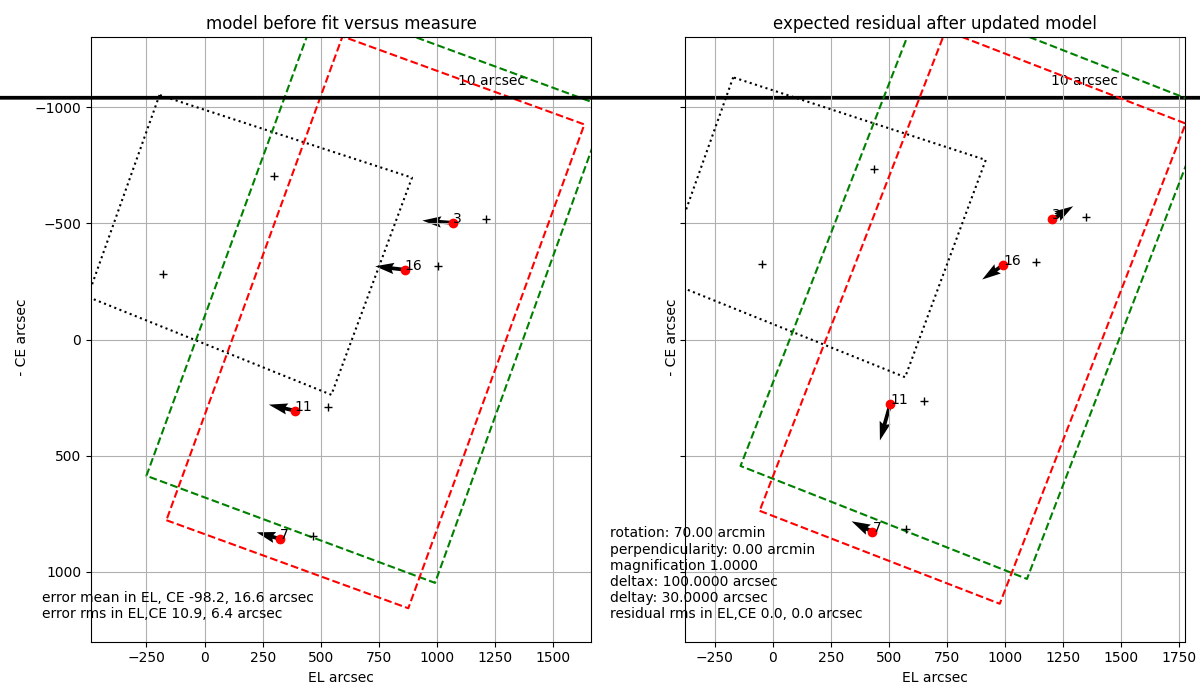


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [97]:
G2UVcor, residuals = G2UV.update_model(slits_coords, slits_coords_obs, plot=True, figsize=(12,7), labels=slits,gamma=False,selected_stars=stars_and_slits, inplace=False)


In [98]:
print(G2UVcor, G2UVcor.FOV_center_guider_coord.to_string('dms'))


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (14.62883, 0.00512)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 69.99999999999979 arcmin
    FOV center in guider: [1571.06344921]x[439.41589029] pix
 ['0d14m20.19810307s -0d01m36.1688792s']


angle = 0.0 degrees

targets local coords in siderostat local frame:
EL: 162.2 arcsec ; CE: 127.0 arcsec
EL: 6.4 arcsec ; CE: -140.6 arcsec
EL: -144.3 arcsec ; CE: -276.9 arcsec

siderostat moves sequence: 
angle = 45.0 degrees

targets local coords in siderostat local frame:
EL: 616.0 arcsec ; CE: 572.7 arcsec
EL: 312.6 arcsec ; CE: 491.5 arcsec
EL: 107.7 arcsec ; CE: 499.4 arcsec

siderostat moves sequence: 
angle = 90.0 degrees

targets local coords in siderostat local frame:
EL: 948.5 arcsec ; CE: 1031.1 arcsec
EL: 675.3 arcsec ; CE: 1183.8 arcsec
EL: 536.2 arcsec ; CE: 1331.4 arcsec

siderostat moves sequence: 
angle = 135.0 degrees

targets local coords in siderostat local frame:
EL: 783.6 arcsec ; CE: 1501.3 arcsec
EL: 700.7 arcsec ; CE: 1798.5 arcsec
EL: 708.9 arcsec ; CE: 1999.2 arcsec

siderostat moves sequence: 
angle = 180.0 degrees

targets local coords in siderostat local frame:
EL: -209.5 arcsec ; CE: 1928.2 arcsec
EL: -53.7 arcsec ; CE: 2195.7 arcsec
EL: 97.0 arcsec ; C

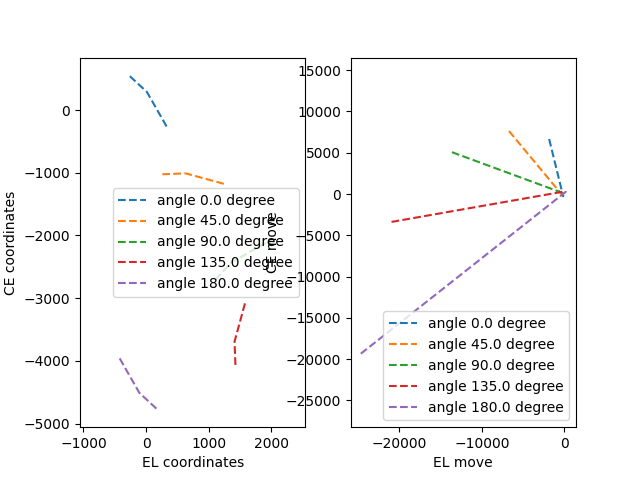

In [99]:
plt.figure()
plt.subplot(1,2,1)
for i in np.linspace(0,180,5):
    print(f"angle = {i} degrees")
    G2UVcor.caroussel_rotation = 0*u.arcsec
    G2UVcor.tank_rotation = i*u.deg
    #stars = ["2", "15", "13", "10"]
    star_moves_rotation, _, star_coords_rotation  = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp=Hysteresis_compensation, CEg=CEg, Elg=Elg)
    plt.plot([c.lon.arcsec for c in star_coords_rotation], [c.lat.arcsec for c in star_coords_rotation], "--", label=f"angle {i} degree")
plt.axis("equal")
plt.xlabel("EL coordinates")
plt.ylabel("CE coordinates")
plt.legend()
plt.subplot(1,2,2)
for i in np.linspace(0,180,5):
    print(f"angle = {i} degrees")
    G2UVcor.caroussel_rotation = 0*u.arcsec
    G2UVcor.tank_rotation = i*u.deg
    #stars = ["2", "15", "13", "10"]
    star_moves_rotation, _, star_coords_rotation  = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp=Hysteresis_compensation, CEg=CEg, Elg=Elg)
    plt.plot(star_moves_rotation[:,0], star_moves_rotation[:,1], "--", label=f"angle {i} degree")
    #plt.plot([c.lon.arcsec for c in star_coords_rotation], [c.lat.arcsec for c in star_coords_rotation], "--", label=f"angle {i} degree")
plt.axis("equal")
plt.xlabel("EL move")
plt.ylabel("CE move")
plt.legend()